In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import PandasTools

from preprocess import getMolDescriptors

from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler


# Predicting HIV Replication Inhibition with Machine Learning

This notebook demonstrates our process of building a machine learning (ML) model to predict whether a molecule inhibits HIV replication. The workflow is designed to address several key challenges and objectives:

## Objectives

- **Interpretable Chemical Descriptors:**  
    The primary goal is to use chemical descriptors that are interpretable, allowing for insights into which molecular features contribute to HIV inhibition.

- **Feature Selection & Importance:**  
    Special emphasis is placed on selecting relevant features (and reducing the dataset dimensionality) and quantifying their importance. Techniques such as correlation analysis, variance thresholding, and permutation importance are employed to identify descriptors that most strongly influence model predictions.

- **Class Imbalance:**  
    The dataset contains a large imbalance between active and inactive molecules, with far fewer inhibitors than non-inhibitors. This imbalance poses a significant challenge for model training and evaluation, especially when using classical ML models.

## Workflow Overview

1. **Data Preparation:**  
     - Molecular data is loaded and chemical descriptors are computed.
     - Molecule objects are generated from SMILES strings for descriptor calculation.

2. **Feature Engineering:**  
     - Features with low variance or high correlation are removed to reduce redundancy.

3. **Feature Selection:**  
     - Statistical methods and model-based selectors are used to identify the most informative descriptors.
     - Feature importance is assessed using permutation importance and repeated model training.

4. **Model Training:**  
     - Multiple classification algorithms (e.g., Logistic Regression, Random Forest, SVC) are trained.

5. **Evaluation & Interpretation:**  
     - Models are evaluated using metrics such as ROC AUC, precision, recall, and F1-score.
     - Feature importance (using permuration importance) is visualized to highlight key molecular descriptors.

## Key Insights

- **Interpretability:**  
    By focusing on interpretable descriptors and robust feature selection, the models provide actionable insights into molecular properties associated with HIV inhibition.

- **Robustness:**  
    Repeated subsampling and evaluation across different data splits ensure that findings are not artifacts of class imbalance or specific data partitions.

- **Generalizability:**  
    The approach enables reliable prediction of HIV activity and identifies stable, meaningful features for future research and drug development.


In [6]:
data = pd.read_csv("data/HIV.csv")
PandasTools.AddMoleculeColumnToFrame(data, smilesCol='smiles', molCol='Molecule')


[14:47:02] Explicit valence for atom # 3 Al, 6, is greater than permitted
[14:47:02] Explicit valence for atom # 5 B, 5, is greater than permitted
[14:47:04] Explicit valence for atom # 16 Al, 9, is greater than permitted
[14:47:05] Explicit valence for atom # 4 Al, 9, is greater than permitted
[14:47:07] Explicit valence for atom # 12 Al, 7, is greater than permitted
[14:47:07] Explicit valence for atom # 13 Al, 7, is greater than permitted
[14:47:08] WARNING: not removing hydrogen atom without neighbors
[14:47:08] WARNING: not removing hydrogen atom without neighbors
[14:47:08] Explicit valence for atom # 6 Ge, 5, is greater than permitted


,smiles,activity,HIV_active,Molecule
0,CCC1=[O+][Cu-3]2([O+]=C(CC)C1)[O+]=C(CC)CC(CC)...,CI,0,
1,C(=Cc1ccccc1)C1=[O+][Cu-3]2([O+]=C(C=Cc3ccccc3...,CI,0,
2,CC(=O)N1c2ccccc2Sc2c1ccc1ccccc21,CI,0,
3,Nc1ccc(C=Cc2ccc(N)cc2S(=O)(=O)O)c(S(=O)(=O)O)c1,CI,0,
4,O=S(=O)(O)CCS(=O)(=O)O,CI,0,
...,...,...,...,...
41122,CCC1CCC2c3c([nH]c4ccc(C)cc34)C3C(=O)N(N(C)C)C(...,CI,0,
41123,Cc1ccc2[nH]c3c(c2c1)C1CCC(C(C)(C)C)CC1C1C(=O)N...,CI,0,
41124,Cc1ccc(N2C(=O)C3c4[nH]c5ccccc5c4C4CCC(C(C)(C)C...,CI,0,
41125,Cc1cccc(N2C(=O)C3c4[nH]c5ccccc5c4C4CCC(C(C)(C)...,CI,0,

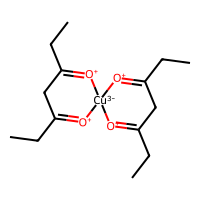
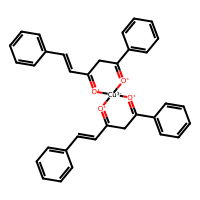
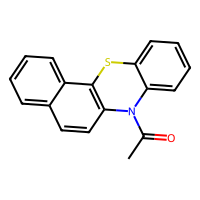
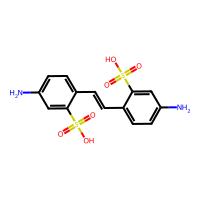
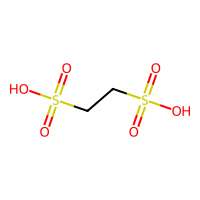
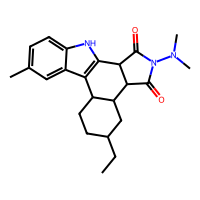
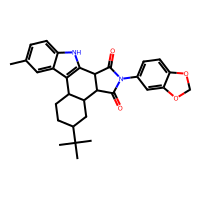
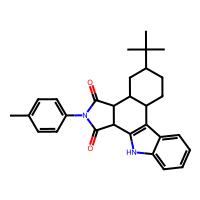
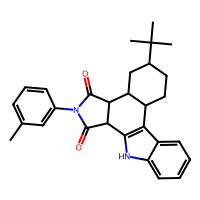
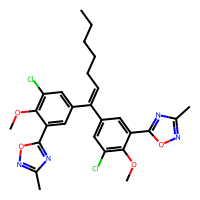

In [7]:
data

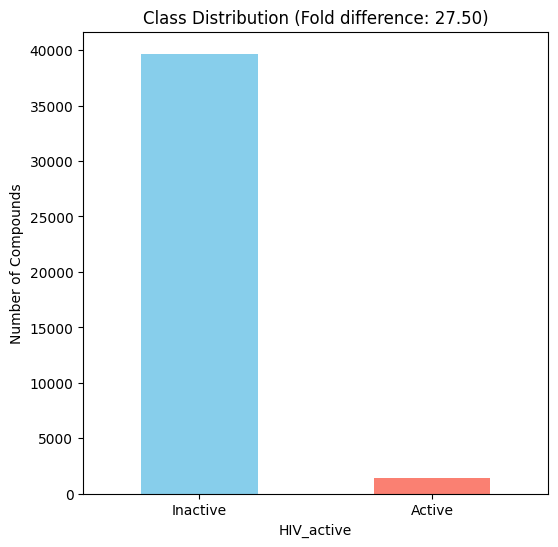

In [59]:
class_counts = data['HIV_active'].value_counts()

plt.figure(figsize=(6, 6))
class_counts.plot(kind='bar', color=['skyblue', 'salmon'])
plt.xticks(ticks=[0, 1], labels=['Inactive', 'Active'], rotation=0)
plt.ylabel('Number of Compounds')
plt.title('Class Distribution (Fold difference: {:.2f})'.format(class_counts.max() / class_counts.min()))
plt.show()

In [7]:
getMolDescriptors(data['Molecule'][0])

{'MaxAbsEStateIndex': np.float64(5.925902777777779),
 'MaxEStateIndex': np.float64(5.925902777777779),
 'MinAbsEStateIndex': np.float64(0.759994212962963),
 'MinEStateIndex': np.float64(-2.3300115740740743),
 'qed': 0.4343577626448334,
 'SPS': 23.36842105263158,
 'MolWt': 319.8880000000001,
 'HeavyAtomMolWt': 295.696,
 'ExactMolWt': 319.09650816808994,
 'NumValenceElectrons': 114,
 'NumRadicalElectrons': 0,
 'MaxPartialCharge': nan,
 'MinPartialCharge': nan,
 'MaxAbsPartialCharge': nan,
 'MinAbsPartialCharge': nan,
 'FpDensityMorgan1': 0.631578947368421,
 'FpDensityMorgan2': 0.8947368421052632,
 'FpDensityMorgan3': 1.105263157894737,
 'BCUT2D_MWHI': nan,
 'BCUT2D_MWLOW': nan,
 'BCUT2D_CHGHI': nan,
 'BCUT2D_CHGLO': nan,
 'BCUT2D_LOGPHI': nan,
 'BCUT2D_LOGPLOW': nan,
 'BCUT2D_MRHI': nan,
 'BCUT2D_MRLOW': nan,
 'AvgIpc': 2.45192843933087,
 'BalabanJ': np.float64(2.470867093556556),
 'BertzCT': 386.3278612823769,
 'Chi0': np.float64(13.880468888623982),
 'Chi0n': 12.177145193552503,
 'Chi0

In [ ]:
_data = data
features = [getMolDescriptors(mol) for mol in _data['Molecule']]

# this takes quite some time, so we save the intermediate result
featured_df = pd.DataFrame(features)
featured_df['y'] = _data['HIV_active'].values

featured_df.to_csv('data/HIV_descriptors.csv', index=False)

In [2]:
featured_df = pd.read_csv('data/HIV_descriptors.csv')

## Feature Selection Workflow

1. **Variance Thresholding:**  
    Removed features with zero variance to eliminate non-informative descriptors.

2. **Correlation Analysis:**  
    Computed pairwise feature correlations and dropped highly correlated features (correlation > 0.8) to reduce redundancy.

3. **Target Correlation Ranking:**  
    Ranked features by their absolute correlation with the target variable and selected the top descriptors.

4. (*Model-Based Selection:* (During training))
    Applied sequential feature selection and permutation importance during model training to identify the most predictive and robust features.

In [3]:
# drop columns with missing values
featured_df = featured_df.dropna(axis=0)
featured_df.shape
y = featured_df['y']
X = featured_df.drop(columns=['y'])

In [4]:
selector = VarianceThreshold(threshold=0.0)
selector.fit(X)
columns = selector.get_support(indices=True)
print(f"Removed {X.shape[1] - len(columns)} features with zero variance.")
X = X.iloc[:,columns]

Removed 4 features with zero variance.


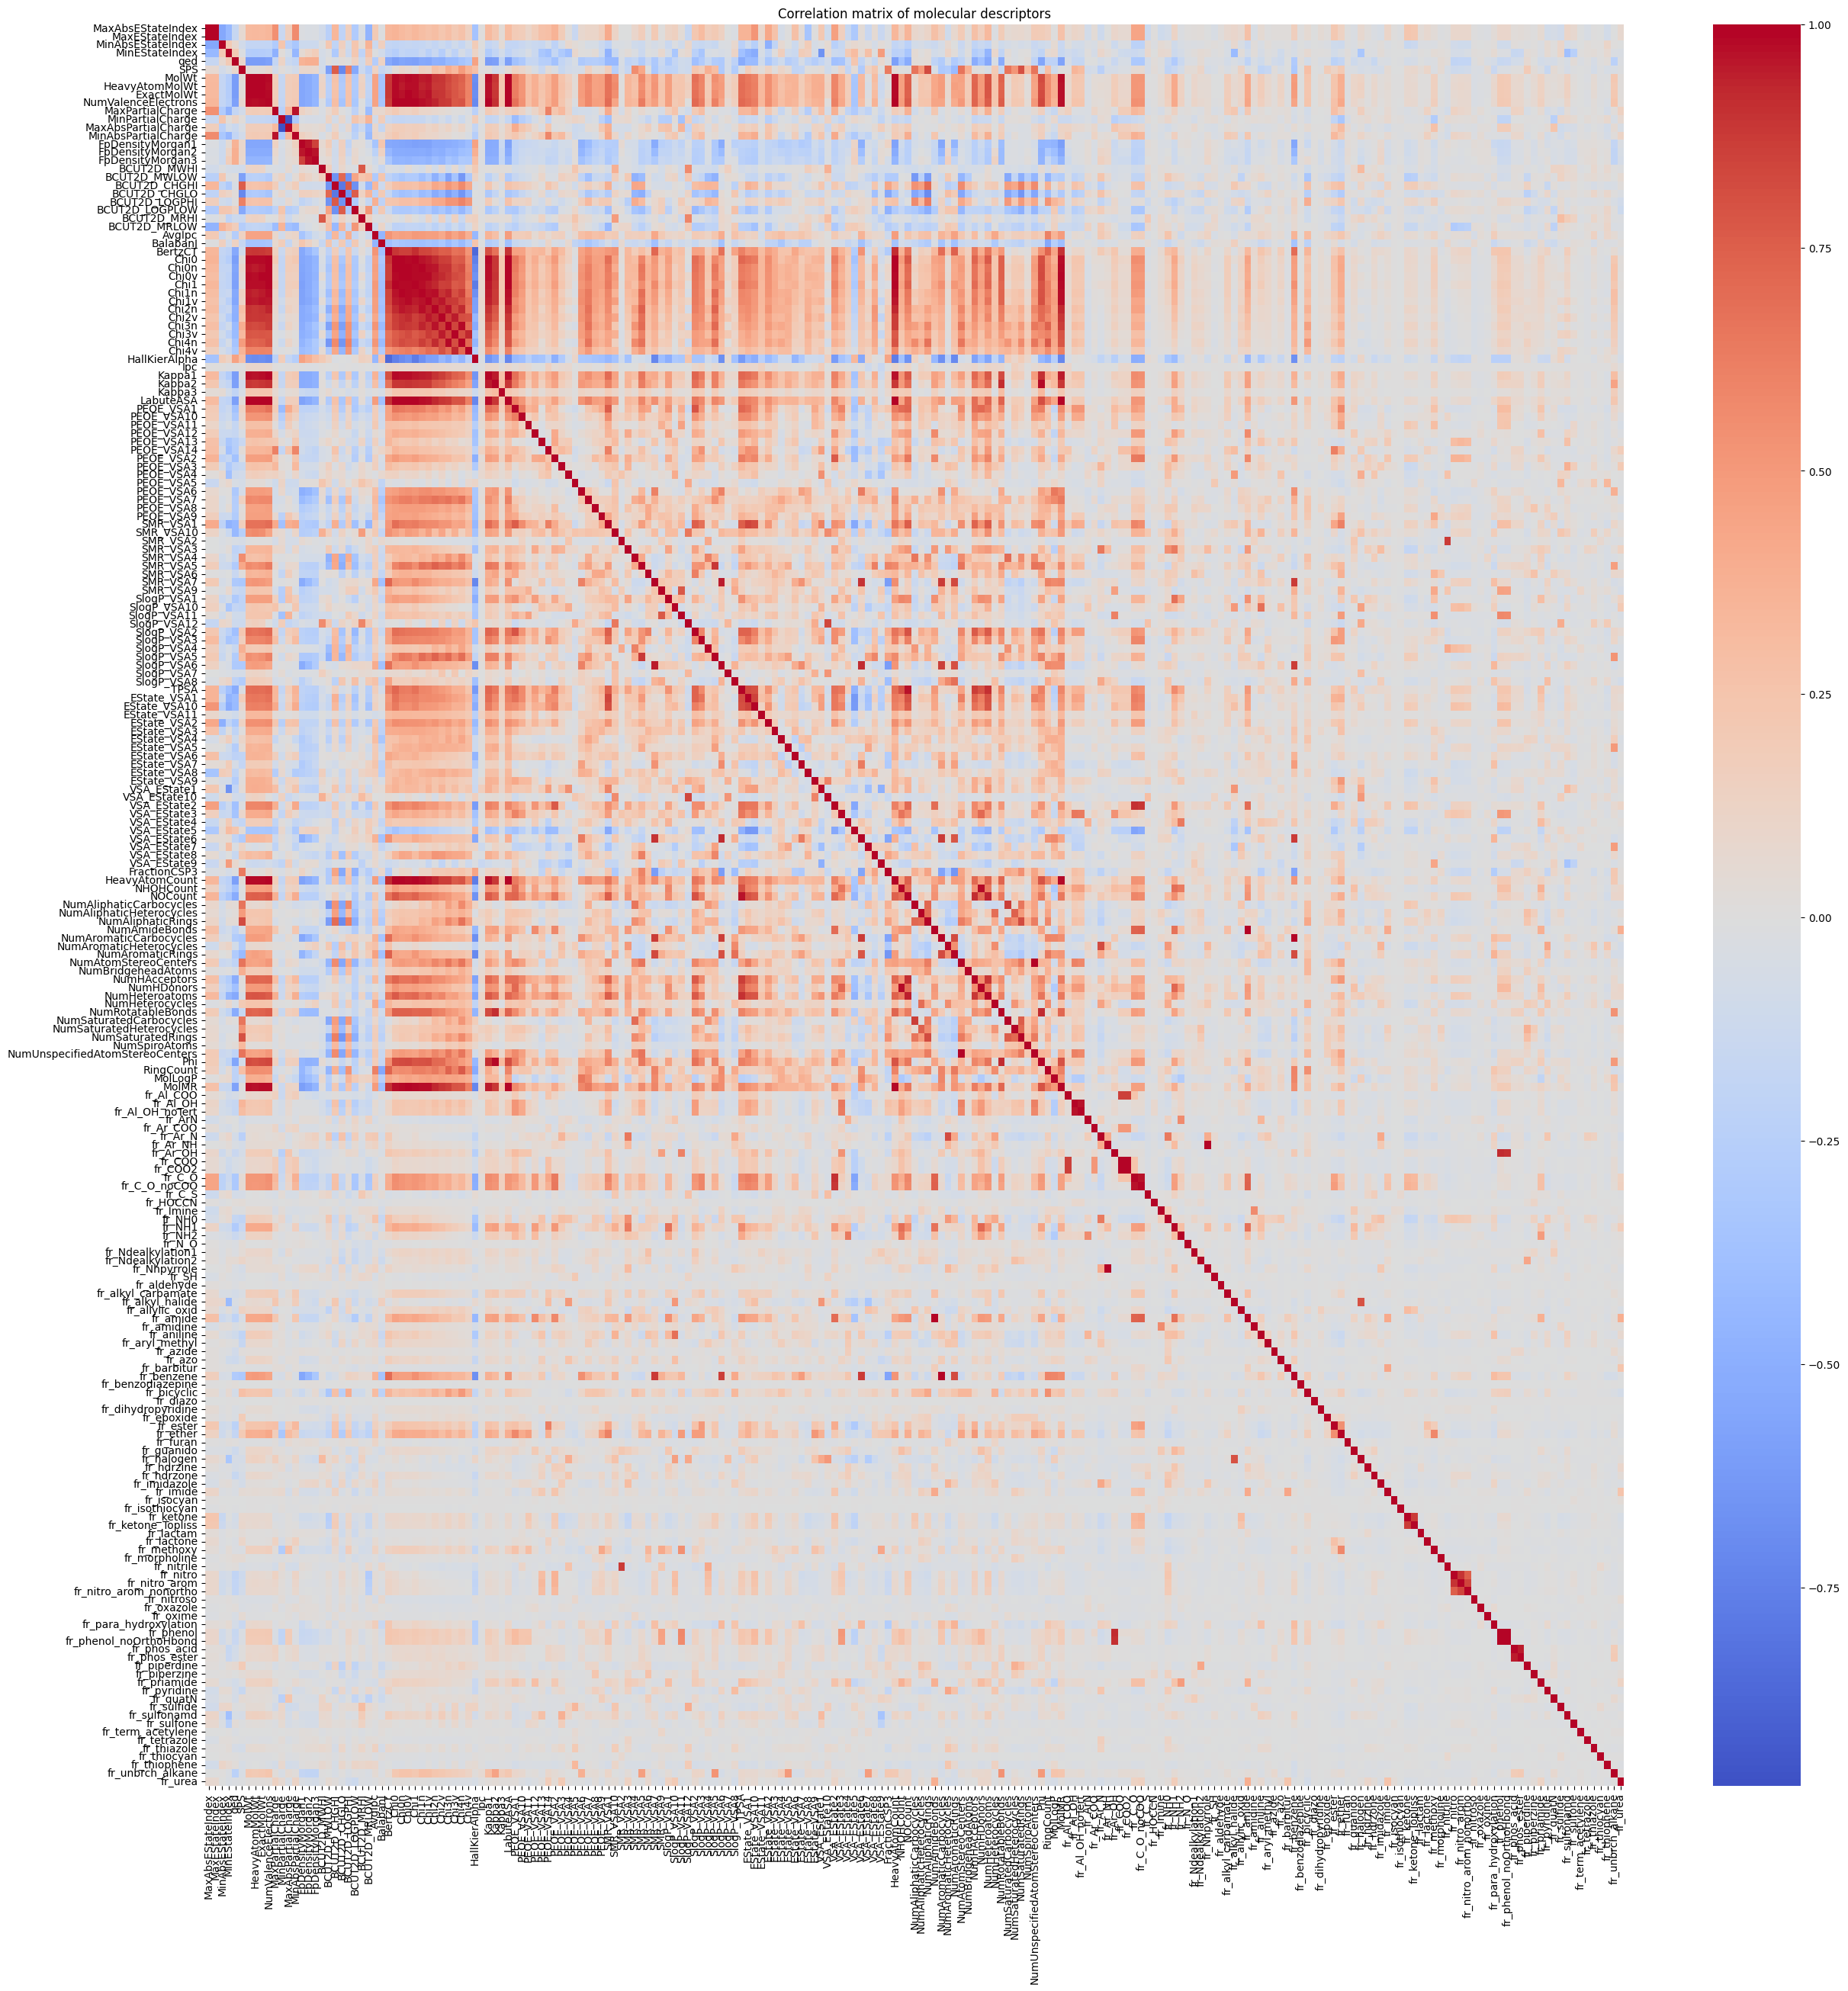

In [5]:
# calculate correlation value of each pair of features
corr_matrix = X.corr()

# make a heatmap of the correlation matrix
plt.figure(figsize=(30,30))
sns.heatmap(corr_matrix, cmap='coolwarm', center=0, xticklabels=X.columns, yticklabels=X.columns)
plt.title('Correlation matrix of molecular descriptors')
plt.show()

In [6]:
# Remove highly correlated features
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper_tri.columns if any(upper_tri[column].abs() > 0.8)]


In [8]:
upper_tri

,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,MaxPartialCharge,MinPartialCharge,MaxAbsPartialCharge,MinAbsPartialCharge,FpDensityMorgan1,FpDensityMorgan2,FpDensityMorgan3,BCUT2D_MWHI,BCUT2D_MWLOW,BCUT2D_CHGHI,BCUT2D_CHGLO,BCUT2D_LOGPHI,BCUT2D_LOGPLOW,BCUT2D_MRHI,BCUT2D_MRLOW,AvgIpc,BalabanJ,BertzCT,Chi0,Chi0n,Chi0v,Chi1,Chi1n,Chi1v,Chi2n,Chi2v,Chi3n,Chi3v,Chi4n,Chi4v,...,fr_halogen,fr_hdrzine,fr_hdrzone,fr_imidazole,fr_imide,fr_isocyan,fr_isothiocyan,fr_ketone,fr_ketone_Topliss,fr_lactam,fr_lactone,fr_methoxy,fr_morpholine,fr_nitrile,fr_nitro,fr_nitro_arom,fr_nitro_arom_nonortho,fr_nitroso,fr_oxazole,fr_oxime,fr_para_hydroxylation,fr_phenol,fr_phenol_noOrthoHbond,fr_phos_acid,fr_phos_ester,fr_piperdine,fr_piperzine,fr_priamide,fr_pyridine,fr_quatN,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
MaxAbsEStateIndex,NaN,1.0,-0.542781,-0.432065,-0.159450,0.065250,0.319553,0.324507,0.319849,0.337772,0.540579,-0.146401,0.161388,0.562198,-0.018771,-0.034508,-0.029428,-0.090814,-0.234025,0.345132,-0.205634,0.162425,-0.288090,-0.035760,-0.466216,0.205221,-0.012164,0.342127,0.357080,0.314570,0.291981,0.332676,0.298367,0.267815,0.297068,0.244148,0.288388,0.210357,0.263756,0.147335,...,0.073323,0.021069,-0.024752,-0.050962,0.108153,0.007943,-0.016478,0.244225,0.220589,0.035095,0.071295,0.031724,-0.011881,0.002999,0.088921,0.091000,0.084860,0.004875,-0.010356,-0.018317,0.031288,0.097860,0.096581,0.025923,0.032053,0.015971,0.002415,0.058195,-0.081711,-0.055795,-0.092810,0.113268,0.069821,-0.002035,-0.047160,0.005268,-0.006722,-0.081215,-0.006264,0.073570
MaxEStateIndex,NaN,NaN,-0.542781,-0.432065,-0.159450,0.065250,0.319553,0.324507,0.319849,0.337772,0.540579,-0.146401,0.161388,0.562198,-0.018771,-0.034508,-0.029428,-0.090814,-0.234025,0.345132,-0.205634,0.162425,-0.288090,-0.035760,-0.466216,0.205221,-0.012164,0.342127,0.357080,0.314570,0.291981,0.332676,0.298367,0.267815,0.297068,0.244148,0.288388,0.210357,0.263756,0.147335,...,0.073323,0.021069,-0.024752,-0.050962,0.108153,0.007943,-0.016478,0.244225,0.220589,0.035095,0.071295,0.031724,-0.011881,0.002999,0.088921,0.091000,0.084860,0.004875,-0.010356,-0.018317,0.031288,0.097860,0.096581,0.025923,0.032053,0.015971,0.002415,0.058195,-0.081711,-0.055795,-0.092810,0.113268,0.069821,-0.002035,-0.047160,0.005268,-0.006722,-0.081215,-0.006264,0.073570
MinAbsEStateIndex,NaN,NaN,NaN,0.199459,0.068379,-0.086184,-0.173699,-0.174157,-0.173767,-0.184460,-0.292146,0.246075,-0.235801,-0.330177,-0.118506,-0.118121,-0.118607,-0.015511,0.217578,-0.199838,0.159213,-0.097253,0.241152,0.039321,0.367635,-0.130113,0.158975,-0.174191,-0.186582,-0.175248,-0.161740,-0.174532,-0.166244,-0.128615,-0.177510,-0.120635,-0.174071,-0.097981,-0.164664,-0.063115,...,0.024679,-0.018252,-0.016251,0.016743,-0.027781,-0.001651,0.003576,-0.147815,-0.129086,-0.018453,-0.020966,-0.025684,0.009284,-0.010566,-0.092151,-0.105758,-0.105331,0.001176,-0.006450,0.003563,0.020299,-0.098020,-0.094475,0.017825,0.005473,-0.013796,0.008652,-0.018978,0.058362,0.012566,0.092415,-0.078126,-0.034146,-0.002925,0.021985,0.012624,0.010806,0.109916,0.010361,-0.001790
MinEStateIndex,NaN,NaN,NaN,NaN,0.198973,-0.019951,-0.267154,-0.277104,-0.267312,-0.251570,-0.483785,0.023605,-0.085347,-0.442501,0.050375,0.126591,0.180976,-0.069860,-0.022908,-0.299028,0.114098,-0.130570,0.225211,-0.204961,0.265919,-0.011169,-0.090127,-0.213070,-0.261892,-0.185925,-0.206559,-0.205192,-0.146683,-0.236429,-0.141791,-0.260022,-0.097976,-0.211549,-0.058205,-0.145062,...,-0.331774,-0.009139,-0.020268,0.032572,-0.014622,-0.008842,-0.002273,-0.008987,-0.030711,0.007135,-0.008222,0.040613,0.027839,0.010743,-0.069189,-0.066044,-0.042360,0.018636,0.008911,0.006250,0.058443,-0.022846,-0.017761,-0.152805,-0.143259,0.038237,0.016465,-0.036278,0.054404,0.013045,0.100908,-0.379926,-0.244031,0.006815,0.022561,0.036800,0.010155,

In [7]:
print(f"Dropping {len(to_drop)} highly correlated features.")
print(f"columns included: {to_drop[:10]} ...")
# drop the highly correlated features
X = X.drop(columns=to_drop)


Dropping 61 highly correlated features.
columns included: ['MaxEStateIndex', 'HeavyAtomMolWt', 'ExactMolWt', 'NumValenceElectrons', 'MaxAbsPartialCharge', 'MinAbsPartialCharge', 'FpDensityMorgan2', 'FpDensityMorgan3', 'BertzCT', 'Chi0'] ...


In [10]:
X

,MaxAbsEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,MaxPartialCharge,MinPartialCharge,FpDensityMorgan1,BCUT2D_MWHI,BCUT2D_MWLOW,BCUT2D_CHGHI,BCUT2D_CHGLO,BCUT2D_LOGPHI,BCUT2D_LOGPLOW,BCUT2D_MRHI,BCUT2D_MRLOW,AvgIpc,BalabanJ,Ipc,Kappa3,PEOE_VSA1,PEOE_VSA10,PEOE_VSA11,PEOE_VSA12,PEOE_VSA13,PEOE_VSA14,PEOE_VSA2,PEOE_VSA3,PEOE_VSA4,PEOE_VSA5,PEOE_VSA6,PEOE_VSA7,PEOE_VSA8,PEOE_VSA9,SMR_VSA1,SMR_VSA10,SMR_VSA2,SMR_VSA3,SMR_VSA4,...,fr_diazo,fr_dihydropyridine,fr_epoxide,fr_ester,fr_ether,fr_furan,fr_guanido,fr_halogen,fr_hdrzine,fr_hdrzone,fr_imidazole,fr_imide,fr_isocyan,fr_isothiocyan,fr_ketone,fr_lactam,fr_lactone,fr_methoxy,fr_morpholine,fr_nitro,fr_nitroso,fr_oxazole,fr_oxime,fr_para_hydroxylation,fr_phos_acid,fr_piperdine,fr_piperzine,fr_priamide,fr_pyridine,fr_quatN,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
2,12.177015,0.041001,0.041001,0.581359,12.904762,291.375,0.227991,-0.278994,0.904762,32.166581,10.085465,2.265088,-2.305509,2.500915,-2.252105,7.995965,-0.115439,2.518550,2.051191,1.113048e+05,1.850086,0.000000,0.000000,0.000000,5.907180,0.000000,0.000000,9.694447,0.000000,0.000000,0.0,54.226454,28.971550,16.714704,11.374773,4.794537,39.816286,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,11.401803,0.087790,-4.524487,0.357615,12.583333,370.408,0.294690,-0.398692,0.708333,32.241217,10.114378,2.161662,-2.060790,2.241600,-2.028340,7.857715,0.480421,2.446346,2.586774,1.145208e+05,4.113674,11.467335,9.790967,0.000000,0.000000,20.236254,0.000000,9.105500,0.000000,16.835594,0.0,24.284774,35.392371,11.374773,0.000000,25.941094,43.763066,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,9.857917,0.980324,-4.296481,0.538723,13.400000,190.198,0.265456,-0.285515,0.800000,32.243582,10.962804,2.109469,-1.917374,1.864461,-2.147724,7.891386,0.471615,1.573012,4.047792,6.449349e+01,7.820000,0.000000,0.000000,0.000000,0.000000,20.236254,0.000000,9.105500,0.000000,16.835594,0.0,0.000000,0.000000,0.000000,11.505707,25.941094,20.236254,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,12.095257,0.310361,-3.269722,0.790087,11.437500,263.661,0.432193,-0.292838,1.312500,35.495691,10.319023,2.228263,-2.180271,2.472861,-2.043135,7.550181,0.224732,2.171946,2.788747,3.088507e+03,4.142492,0.000000,0.000000,0.000000,0.000000,0.000000,7.746488,14.134789,4.565048,0.000000,0.0,17.667307,32.046576,10.710020,13.213764,13.612543,25.034815,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,10.261759,0.067130,-1.112870,0.610259,9.200000,138.122,0.338969,-0.507053,1.300000,16.367670,10.187505,2.051200,-1.945616,2.138185,-1.945909,5.900329,0.069352,1.878745,3.152941,1.822382e+02,1.074894,10.213055,11.312963,0.000000,0.000000,0.000000,5.969305,0.000000,4.794537,0.000000,0.0,12.132734,12.132734,0.000000,0.000000,15.007592,5.969305,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41122,13.370142,0.007185,-0.366239,0.804191,32.035714,379.504,0.253334,-0.357464,1.178571

In [8]:
# normalize the features
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
X

,MaxAbsEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,MaxPartialCharge,MinPartialCharge,FpDensityMorgan1,BCUT2D_MWHI,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,0.384700,-0.625915,0.729836,0.277579,-0.527913,-0.436011,-0.432308,1.273904,-0.524627,0.286732,...,-0.25988,-0.180771,-0.124774,-0.055266,-0.050295,-0.166036,-0.022807,-0.133933,-0.154826,-0.167422
1,0.090784,-0.428024,-2.488228,-0.747159,-0.560540,0.041172,0.282648,0.161348,-1.214944,0.291132,...,-0.25988,-0.180771,-0.124774,-0.055266,-0.050295,-0.166036,-0.022807,-0.133933,-0.154826,-0.167422
2,-0.494572,3.346938,-2.327515,0.082308,-0.477643,-1.046894,-0.030714,1.213288,-0.892796,0.291271,...,-0.25988,-0.180771,-0.124774,-0.055266,-0.050295,-0.166036,-0.022807,-0.133933,-0.154826,-0.167422
3,0.353702,0.513337,-1.603785,1.233542,-0.676849,-0.603342,1.756557,1.145231,0.908304,0.482999,...,-0.25988,-0.180771,-0.124774,-0.055266,-0.050295,-0.166036,-0.022807,-0.133933,-0.154826,-0.167422
4,-0.341457,-0.515405,-0.083490,0.409936,-0.903969,-1.361317,0.757280,-0.845829,0.864375,-0.644691,...,-0.25988,-0.180771,-0.124774,-0.055266,-0.050295,-0.166036,-0.022807,-0.133933,-0.154826,-0.167422
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39451,0.837068,-0.768938,0.442786,1.298135,1.413999,0.096091,-0.160654,0.544551,0.437633,-0.654825,...,-0.25988,-0.180771,-0.124774,-0.055266,-0.050295,-0.166036,-0.022807,-0.133933,-0.154826,-0.167422
39452,1.136637,-0.481769,0.361945,-0.425966,1.094576,0.730612,-0.269706,-0.348937,-0.287549,-0.625288,...,-0.25988,-0.180771,-0.124774,-0.055266,-0.050295,-0.166036,-0.022807,-0.133933,-0.154826,-0.167422
39453,1.061831,-0.751231,0.408006,-0.319694,1.127386,0.464896,-0.269729,0.544543,-0.402918,-0.655636,...,-0.25988,-0.180771,-0.124774,-0.055266,-0.050295,-0.166036,-0.022807,-0.133933,-0.154826,-0.167422
39454,1.071829,-0.758073,0.407490,-0.319694,1.127386,0.464896,-0.269727,0.544543,-0.296423,-0.655636,...,-0.25988,-0.180771,-0.124774,-0.055266,-0.050295,-0.166036,-0.022807,-0.133933,-0.154826,-0.167422


# PCA analysis

In [39]:
import umap
from sklearn.decomposition import PCA


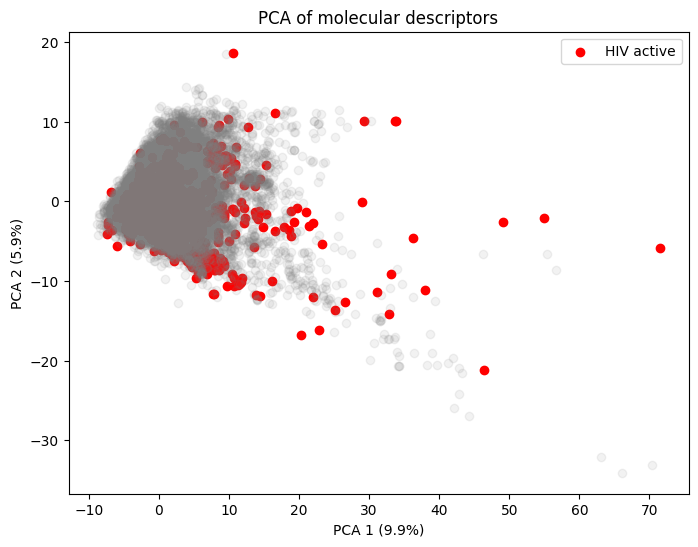

In [38]:
# fit a PCA model
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# plot the PCA result and color by the activity of each data point
plt.figure(figsize=(8,6))
# use class 1 only
X_pca_pos = X_pca[y==1]
X_pca_neg = X_pca[y==0]
plt.scatter(X_pca_pos[:,0], X_pca_pos[:,1], alpha= 1, c='red', label='HIV active')
plt.scatter(X_pca_neg[:,0], X_pca_neg[:,1], c='grey', alpha=0.1)
plt.xlabel(f'PCA 1 (%.1f%%)' % (pca.explained_variance_ratio_[0]*100))
plt.ylabel('PCA 2 (%.1f%%)' % (pca.explained_variance_ratio_[1]*100))
plt.legend()
plt.title('PCA of molecular descriptors')
plt.show()

/Users/julian/opt/anaconda3/envs/r_bio/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


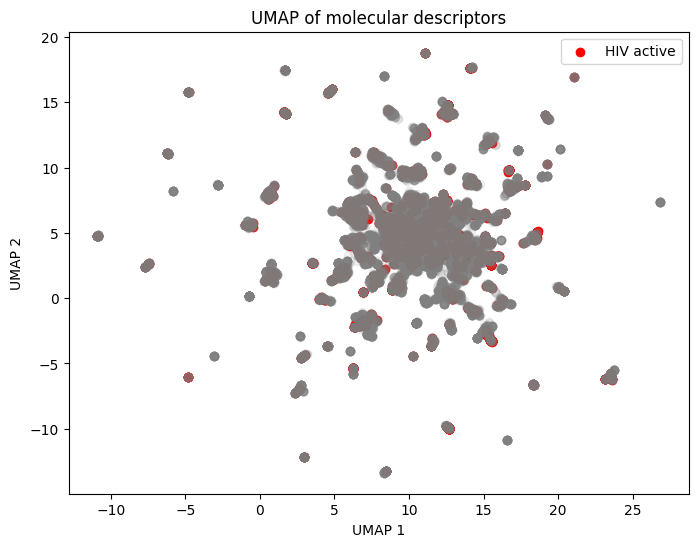

In [45]:
# umap
reducer = umap.UMAP(n_neighbors=15, min_dist=0.05, random_state=42)
X_umap = reducer.fit_transform(X)   


plt.figure(figsize=(8,6))
# use class 1 only
X_umap_pos = X_umap[y==1]
X_umap_neg = X_umap[y==0]
plt.scatter(X_umap_pos[:,0], X_umap_pos[:,1], alpha= 1, c='red', label='HIV active')
plt.scatter(X_umap_neg[:,0], X_umap_neg[:,1], c='grey', alpha=0.1)
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.legend()
plt.title('UMAP of molecular descriptors')
plt.show()

# Feature selection

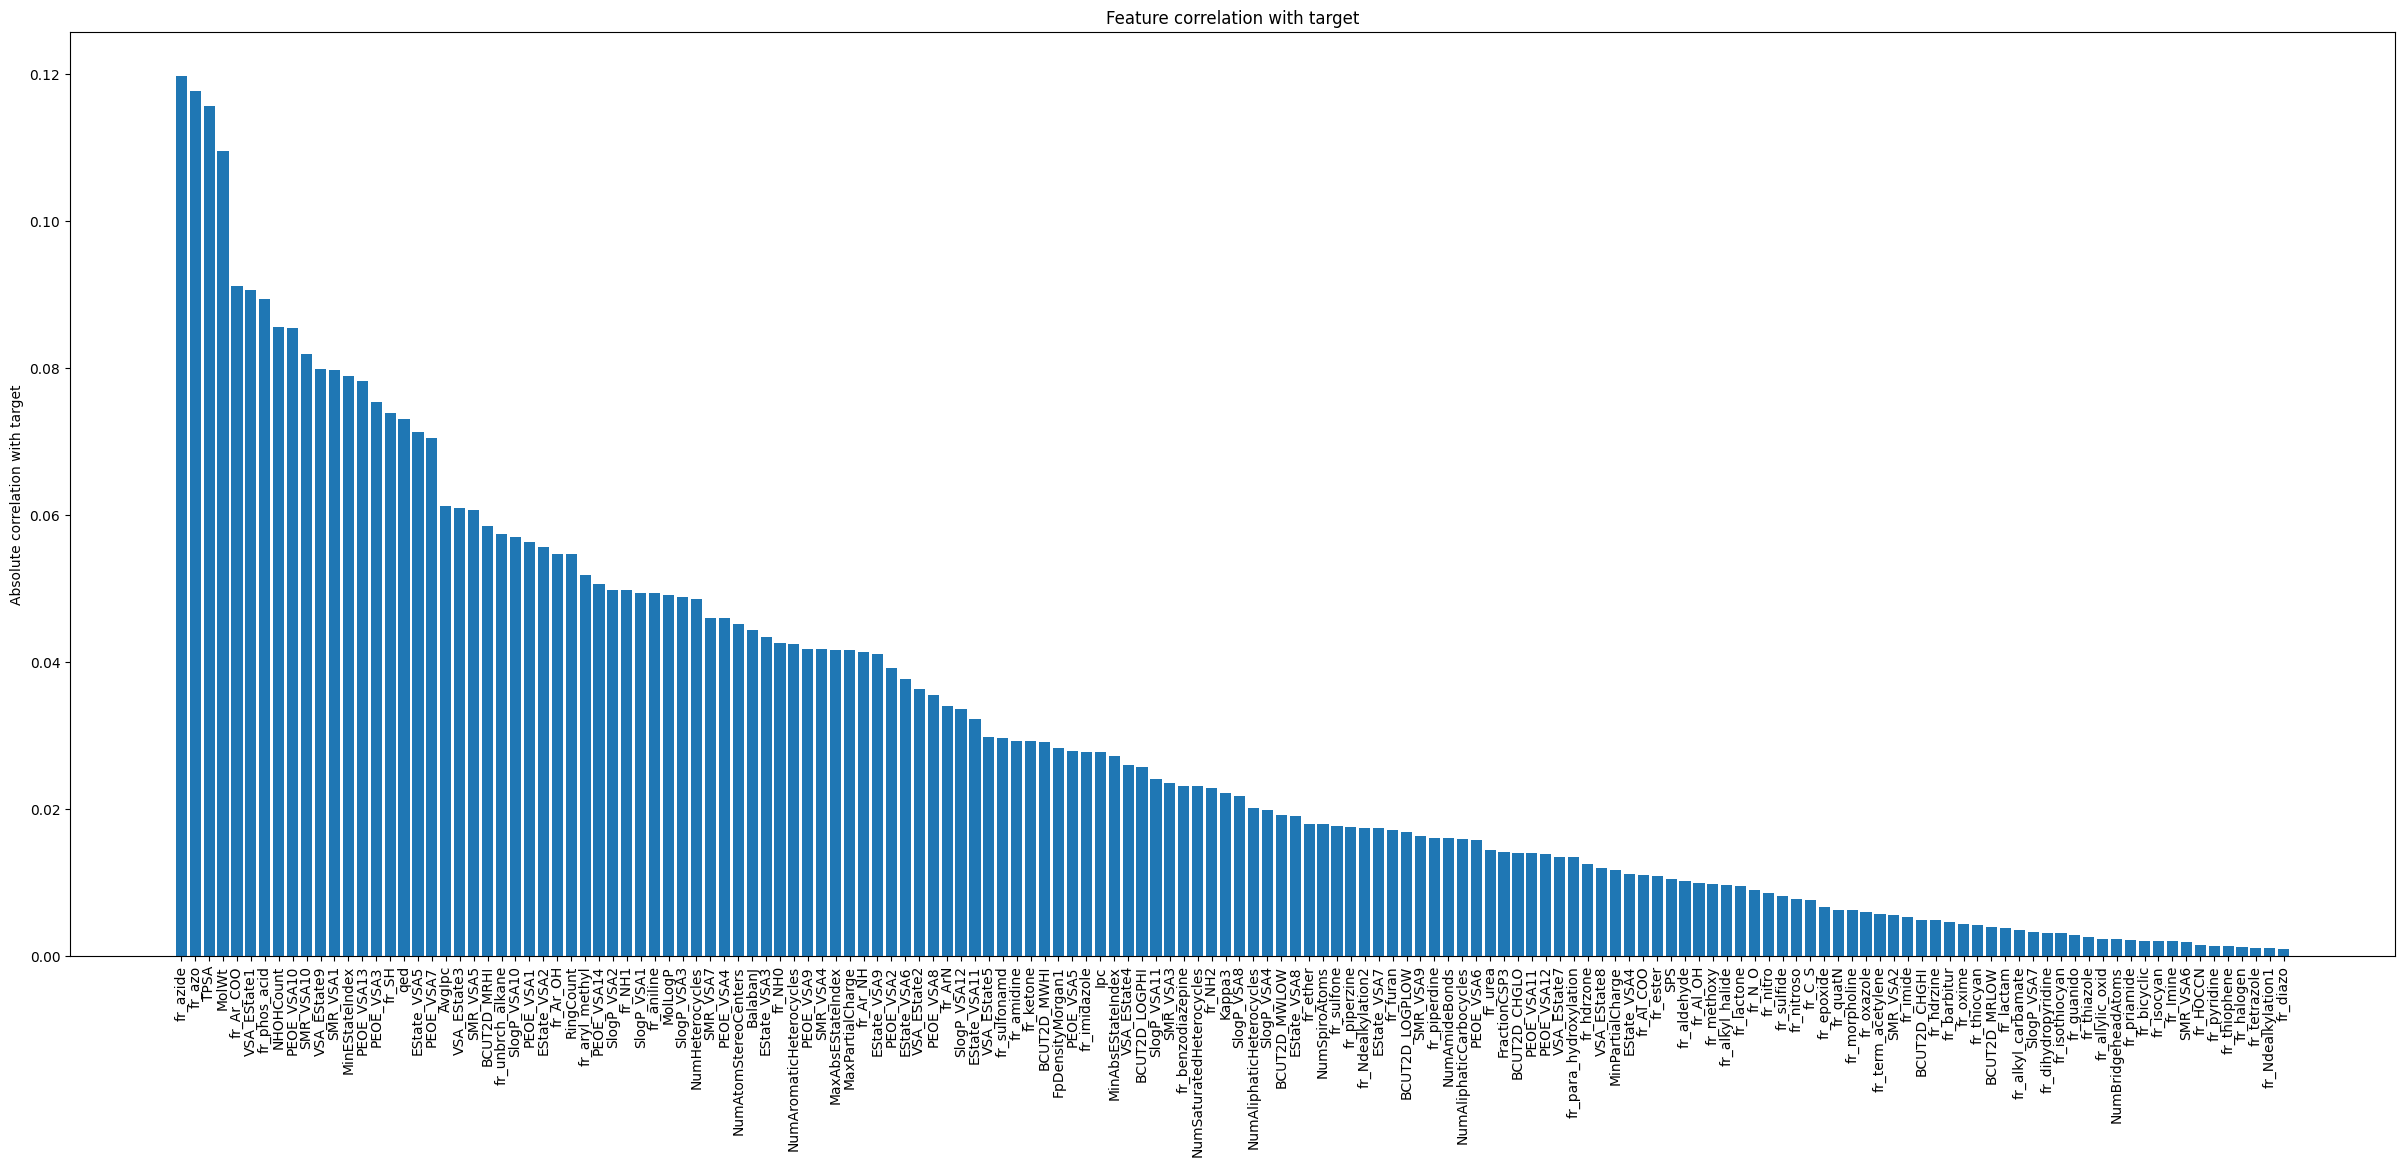

In [9]:
# plot the correlation of each feature with the target
import numpy as np
correlations = X.apply(lambda x: np.corrcoef(x, y)[0,1])
correlations = correlations.abs().sort_values(ascending=False)
plt.figure(figsize=(30,12))
plt.bar(correlations.index, correlations.values)
plt.xticks(rotation=90)
plt.ylabel('Absolute correlation with target')
plt.title('Feature correlation with target')
plt.show()

In [10]:
# 30 most correlated features with the target
corr_features = correlations.head(30)
corr_features

fr_azide            0.119721
fr_azo              0.117604
TPSA                0.115634
MolWt               0.109483
fr_Ar_COO           0.091130
VSA_EState1         0.090584
fr_phos_acid        0.089372
NHOHCount           0.085560
PEOE_VSA10          0.085393
SMR_VSA10           0.081942
VSA_EState9         0.079898
SMR_VSA1            0.079675
MinEStateIndex      0.078878
PEOE_VSA13          0.078268
PEOE_VSA3           0.075407
fr_SH               0.073926
qed                 0.072999
EState_VSA5         0.071310
PEOE_VSA7           0.070408
AvgIpc              0.061213
VSA_EState3         0.060890
SMR_VSA5            0.060683
BCUT2D_MRHI         0.058423
fr_unbrch_alkane    0.057416
SlogP_VSA10         0.056983
PEOE_VSA1           0.056293
EState_VSA2         0.055585
fr_Ar_OH            0.054664
RingCount           0.054631
fr_aryl_methyl      0.051809
dtype: float64

In [11]:
X_selected = X[corr_features.index].reset_index(drop=True)
y = y.reset_index(drop=True)
X_selected['HIV active'] = y

In [32]:
X_selected

,fr_azide,fr_azo,TPSA,MolWt,fr_Ar_COO,VSA_EState1,fr_phos_acid,NHOHCount,PEOE_VSA10,SMR_VSA10,...,SMR_VSA5,BCUT2D_MRHI,fr_unbrch_alkane,SlogP_VSA10,PEOE_VSA1,EState_VSA2,fr_Ar_OH,RingCount,fr_aryl_methyl,HIV active
0,-0.075285,-0.121837,-1.014813,-0.436011,-0.131099,-0.582145,-0.060594,-0.720073,-0.810142,0.787087,...,-0.321878,1.033901,-0.154826,1.004731,-0.997098,-0.661848,-0.281031,0.576027,-0.454017,0
1,-0.075285,-0.121837,1.304390,0.041172,-0.131099,2.650434,-0.060594,1.893132,0.127752,1.004853,...,-0.537444,0.920625,-0.154826,1.004731,-0.085941,0.545746,-0.281031,-0.615715,-0.454017,0
2,-0.075285,-0.121837,0.445193,-1.046894,-0.131099,2.211410,-0.060594,0.150995,-0.810142,-0.293250,...,-0.842280,0.948214,-0.154826,-0.621822,-0.997098,-1.091718,-0.281031,-1.807457,-0.454017,0
3,-0.075285,-0.121837,-0.564907,-0.603342,-0.131099,0.541638,-0.060594,-0.284539,-0.810142,-0.028488,...,-0.411148,0.668646,-0.154826,0.191455,-0.997098,-1.091718,-0.281031,-1.211586,-0.454017,0
4,-0.075285,-0.121837,-0.400299,-1.361317,5.046710,-0.582145,-0.060594,0.150995,0.273546,-1.080436,...,-0.842280,-0.683168,-0.154826,-0.621822,-0.185602,-0.268465,1.218611,-1.211586,-0.454017,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39451,-0.075285,-0.121837,-0.418791,0.096091,-0.131099,-0.582145,-0.060594,-0.284539,-0.810142,-0.156358,...,0.756988,-0.532871,-0.154826,-0.621822,-0.601087,1.059973,-0.281031,1.171897,1.043533,0
39452,-0.075285,-0.121837,-0.167504,0.730612,-0.131099,-0.026946,-0.060594,-0.284539,-0.810142,0.157446,...,0.988212,-0.403468,-0.154826,0.191455,0.151663,1.948353,-0.281031,2.363639,1.043533,0
39453,-0.075285,-0.121837,-0.472284,0.464896,-0.131099,-0.582145,-0.060594,-0.284539,-0.810142,0.157446,...,0.988212,-0.404502,-0.154826,0.191455,-0.601087,1.023375,-0.281031,1.767768,1.043533,0
39454,-0.075285,-0.121837,-0.472284,0.464896,-0.131099,-0.582145,-0.060594,-0.284539,-0.810142,0.157446,...,0.988212,-0.404284,-0.154826,0.191455,-0.601087,1.023375,-0.281031,1.767768,1.043533,0


# Model Training

# Model Evaluation

### Report AUC curve
### find best threshold on the train set
### Report Confusion matrix, as well as precision, recall and F1 Score

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from train import train_eval_model
from plot import plot_model_results, plot_repeated_model_results

NJOBS = 4

In [15]:
models = [
    LogisticRegression(max_iter=100, n_jobs=NJOBS),  
    RandomForestClassifier(random_state=42, n_jobs=NJOBS),
    SVC(probability=True, random_state=42, cache_size=400)
    ]

In [13]:
# construct a logistic regression model to predict HIV_active based on functional group counts

# randomly subsample the majority class to balance the dataset
min_size = y.value_counts().min() 
factor = 4
print('Size of class 1: ', min_size)
print('Size of class 0 after resampling: ', min_size*factor)
balanced_df = pd.concat([
    X_selected[X_selected['HIV active'] == 0].sample(min_size*factor, random_state=42, replace=True),
    X_selected[X_selected['HIV active'] == 1].sample(min_size, random_state=42)
])


X_ = balanced_df.drop(columns=['HIV active'])
y_ = balanced_df['HIV active']


Size of class 1:  1260
Size of class 0 after resampling:  5040


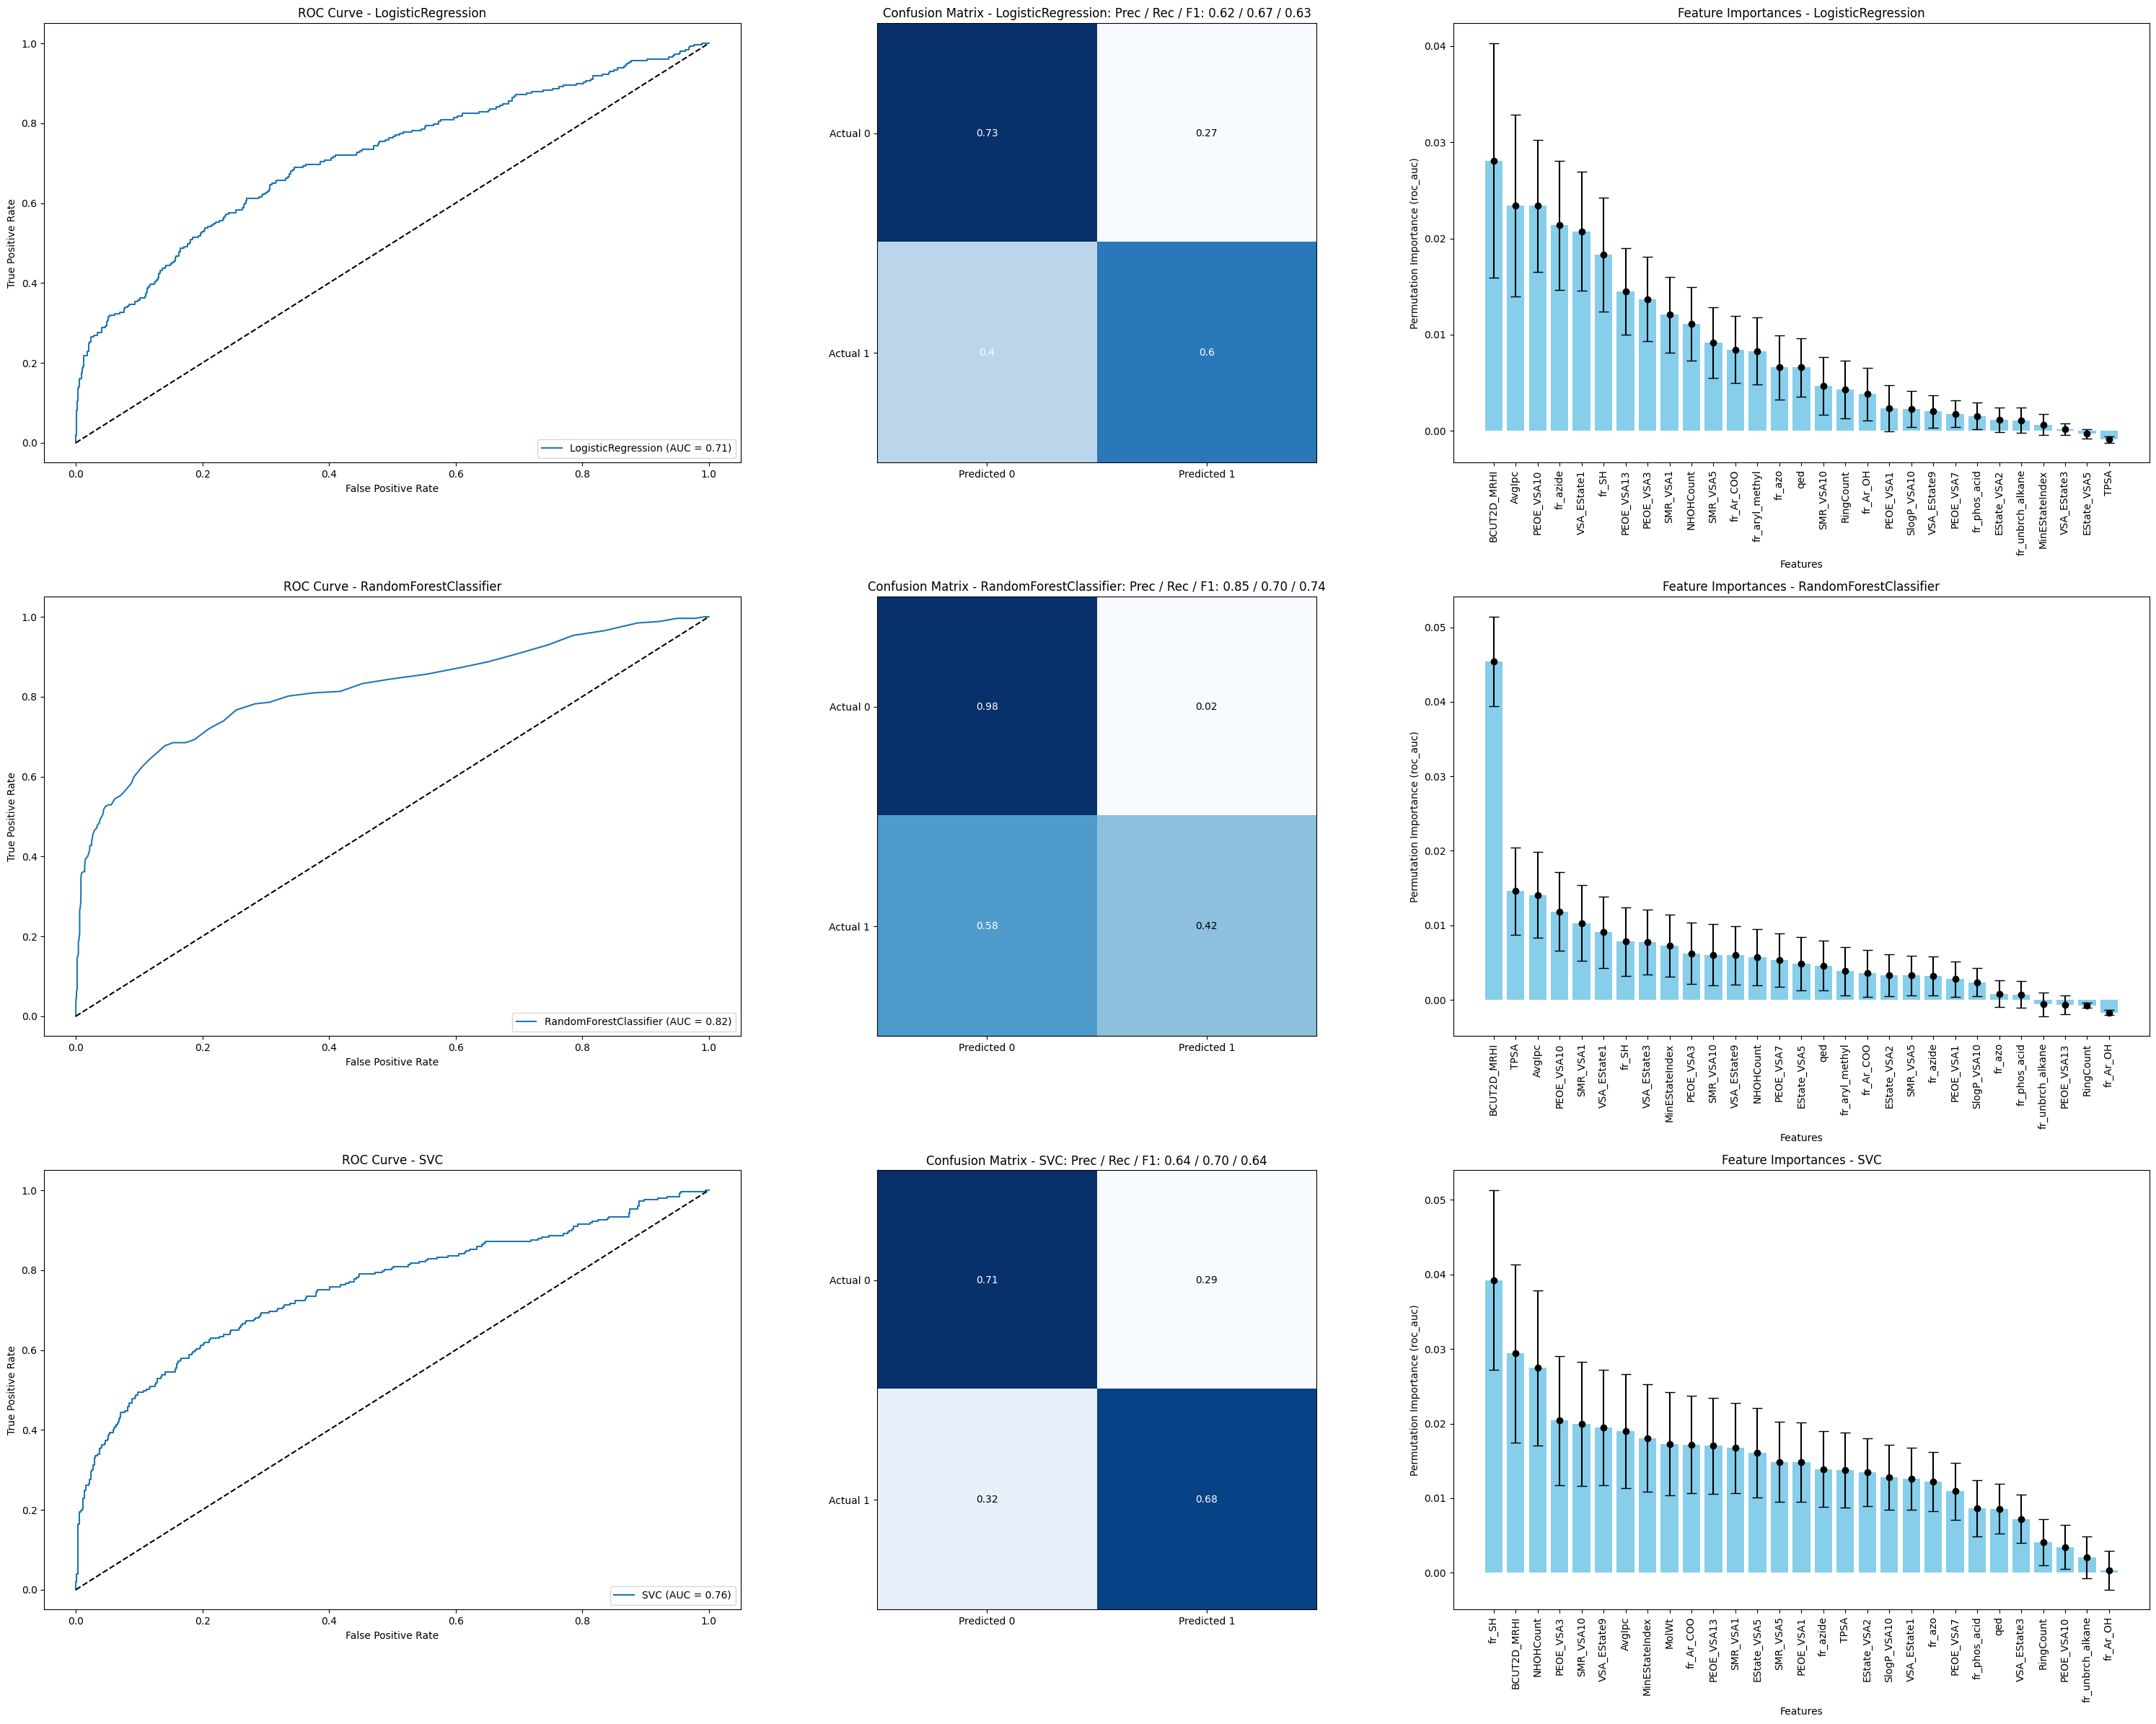

In [ ]:
# run logistic regression and random forest models

for i, model in enumerate(models):
    X_train, X_test, y_train, y_test = train_test_split(X_, y_, test_size=0.2, random_state=42)
    model, tpr, fpr, optimal_threshold, performance_dict, importances = train_eval_model(model, X_train, y_train, X_test, y_test)
    if i == 0:
        fig, axes = plt.subplots(len(models), 3, figsize=(30, 8 * len(models)))
    plot = plot_model_results(i, axes, model.__class__.__name__, tpr, fpr, performance_dict, importances)
    if i == len(models) - 1:
        plt.tight_layout()
        plt.show()


## Robustness Analysis via Repeated Data Splitting

To assess the robustness of our models and the stability of feature importance, we conducted an experiment where the training and evaluation process was repeated across multiple random splits of the dataset. The key aspect of this approach is the random subsampling of the majority (negative) class, which is highly overrepresented in our data. By generating different balanced subsets for each run, we ensure that the models are exposed to diverse examples from the negative class.

### Rationale

- **Class Imbalance:** The dataset contains far more negative samples than positive ones. To avoid bias and overfitting, we balance the data by randomly selecting an equal number of negative and positive samples for each run.
- **Robustness:** Training on different subsets allows us to observe how sensitive the models are to the specific composition of the training data, especially the negative class.
- **Feature Importance Stability:** By comparing feature importances across runs, we can identify which molecular descriptors consistently contribute to model performance and which are more variable.

### Experimental Procedure

1. **Repeated Subsampling:** For each model, we perform five independent runs. In each run, we randomly subsample the negative class to match the size of the positive class, creating a balanced dataset.
2. **Model Training:** The selected models (Logistic Regression, Random Forest, SVC) are trained and evaluated on each split.
3. **Performance Evaluation:** Metrics such as ROC curves, AUC, precision, recall, and F1-score are recorded for each run.
4. **Feature Importance Aggregation:** Permutation importance is calculated for each run, and the mean and standard deviation across runs are reported.

### Insights

This approach provides a more reliable estimate of model generalizability and highlights features that are robust predictors of HIV activity, regardless of the specific negative samples included. It also helps identify features whose importance is sensitive to data splits, informing future feature selection and model development strategies.

Run 1 - Model LogisticRegression
Run 2 - Model LogisticRegression
Run 3 - Model LogisticRegression
Run 4 - Model LogisticRegression
Run 5 - Model LogisticRegression
Run 1 - Model RandomForestClassifier
Run 2 - Model RandomForestClassifier
Run 3 - Model RandomForestClassifier
Run 4 - Model RandomForestClassifier
Run 5 - Model RandomForestClassifier
Run 1 - Model SVC
Run 2 - Model SVC
Run 3 - Model SVC
Run 4 - Model SVC
Run 5 - Model SVC


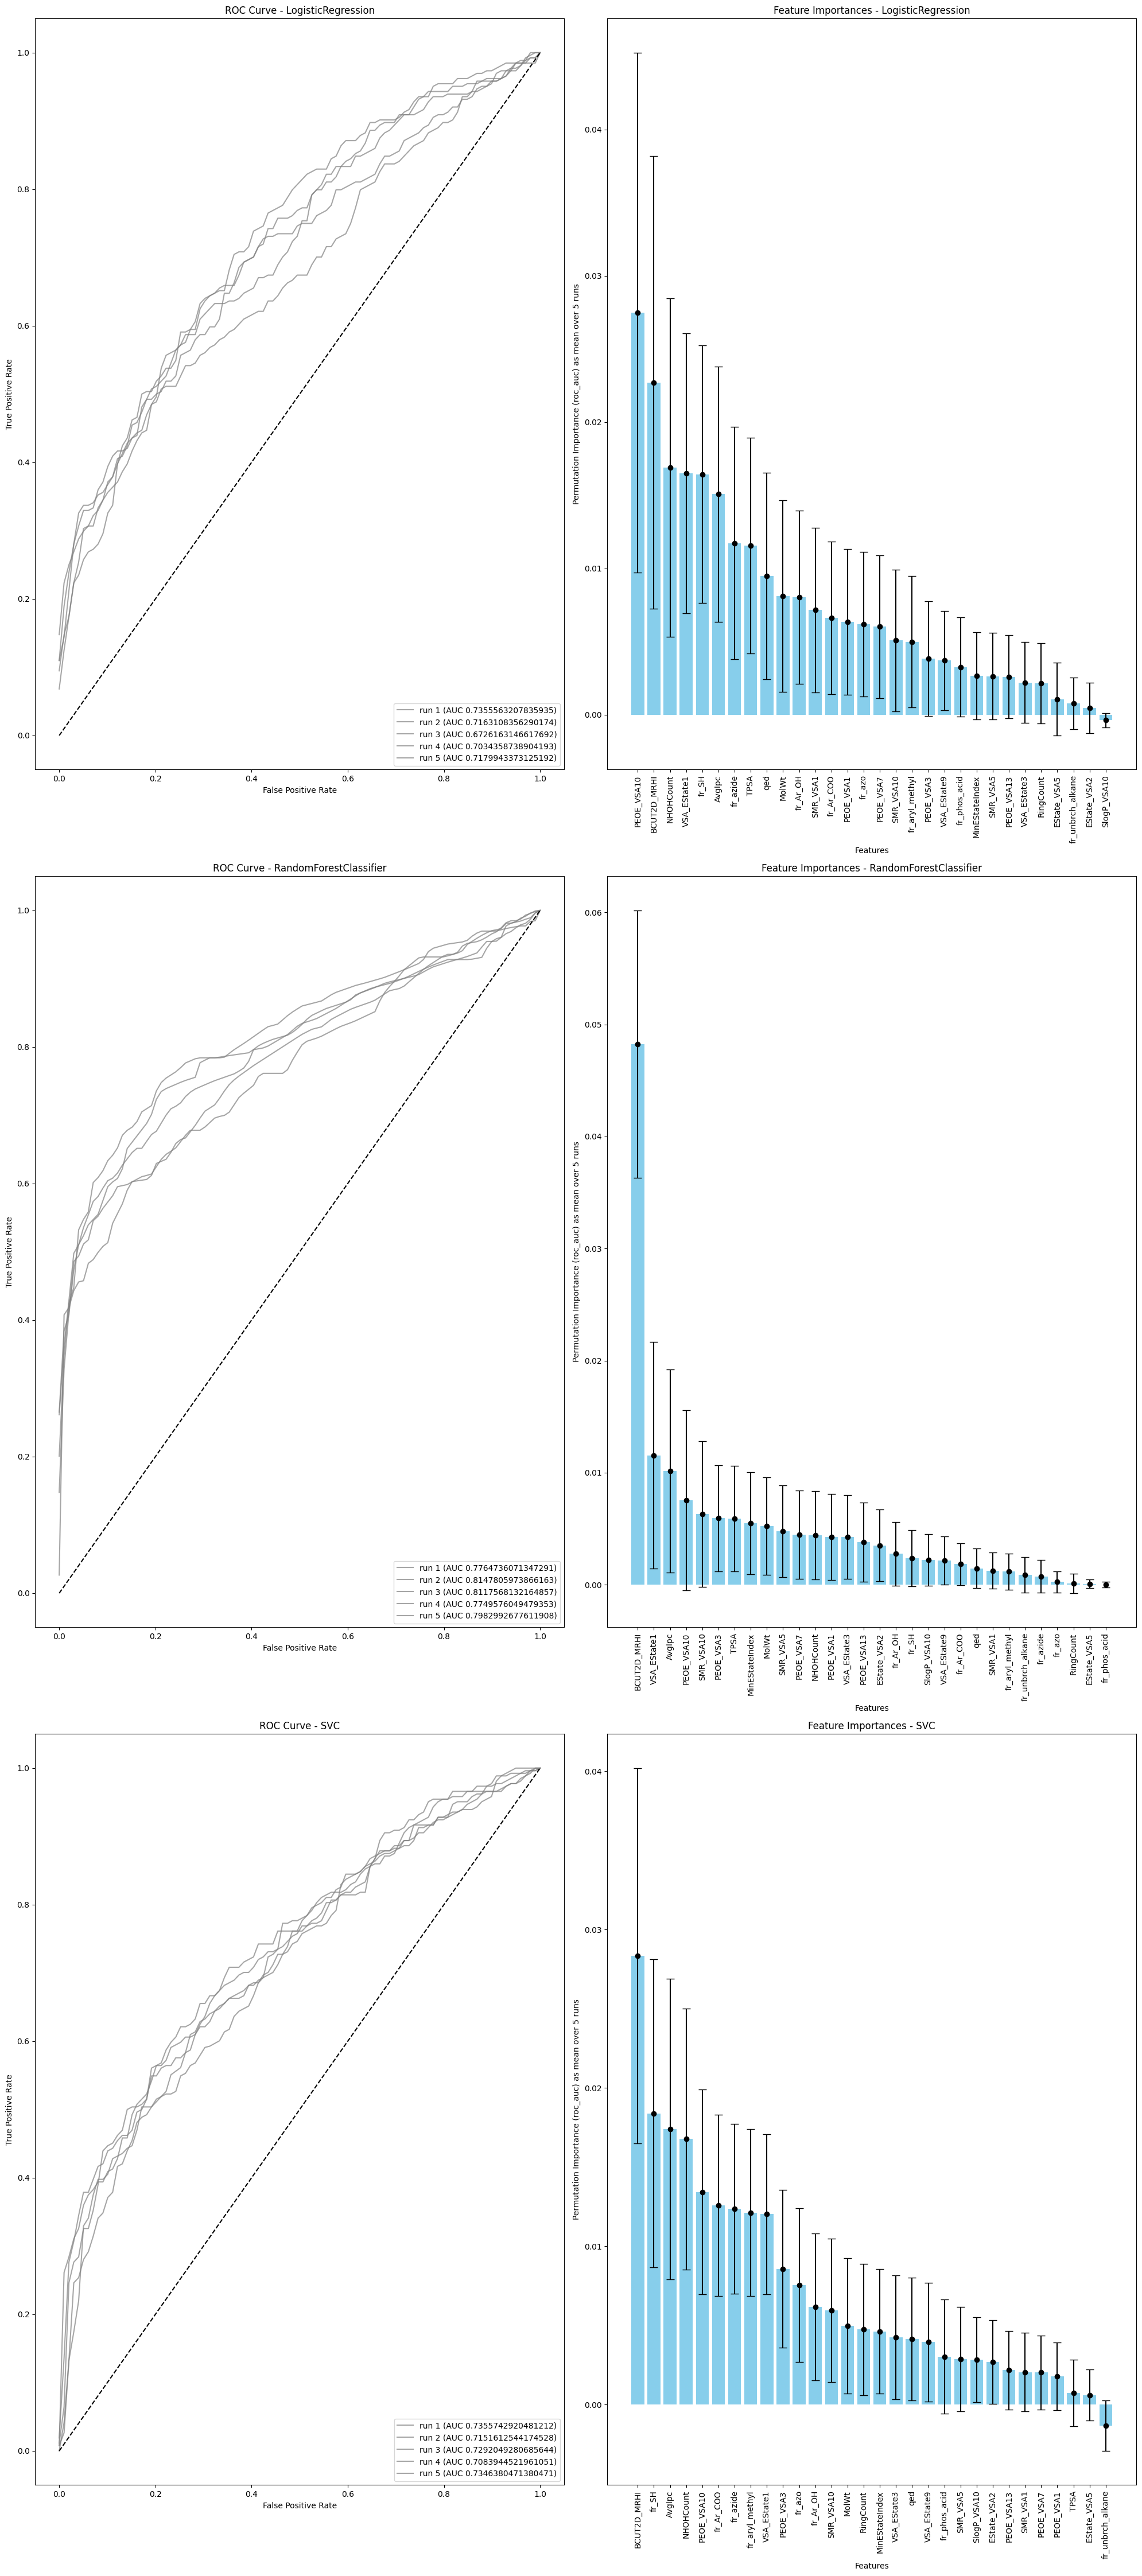

In [ ]:
fig, axes = plt.subplots(len(models), 2, figsize=(20, 10 * len(models)))
for i, model in enumerate(models):
    tpr_list = []
    fpr_list = []
    performance_list = []
    importances_list = []

    for n in range(5):  # 5 different random states for balancing
        min_size = y.value_counts().min() 
        balanced_df = pd.concat([
            X_selected[X_selected['HIV active'] == 0].sample(min_size),
            X_selected[X_selected['HIV active'] == 1].sample(min_size)
        ])


        X_ = balanced_df.drop(columns=['HIV active'])
        y_ = balanced_df['HIV active']
        
        print(f'Run {n+1} - Model {model.__class__.__name__}')
        X_train, X_test, y_train, y_test = train_test_split(X_, y_, test_size=0.2, random_state=42)
        _, tpr, fpr, optimal_threshold, performance_dict, importances = train_eval_model(model, X_train, y_train, X_test, y_test)
        tpr_list.append(tpr)
        fpr_list.append(fpr)
        performance_list.append(performance_dict)
        importances_list.append(importances)

    # aggregate results

    plot = plot_repeated_model_results(i, axes, model.__class__.__name__, tpr_list, fpr_list, performance_dict, importances_list)
plt.tight_layout()
plt.show()

In [18]:
# for different magnitudes of class imbalance
factors = [1, 2, 4, 5, 10, 15, 20]
model_roc_auc = {model.__class__.__name__: [] for model in models}
for factor in factors:
    min_size = y.value_counts().min() 
    balanced_df = pd.concat([
        X_selected[X_selected['HIV active'] == 0].sample(min_size*factor, replace=True),
        X_selected[X_selected['HIV active'] == 1].sample(min_size)
    ])

    for i, model in enumerate(models):
        X_ = balanced_df.drop(columns=['HIV active'])
        y_ = balanced_df['HIV active']
        
        X_train, X_test, y_train, y_test = train_test_split(X_, y_, test_size=0.2, random_state=42)
        _, _, _, _, performance_dict, _ = train_eval_model(model, X_train, y_train, X_test, y_test, feature_importance=False)
        roc_auc = performance_dict['auc']
        print(f'Class imbalance factor: {factor}, Model: {model.__class__.__name__}, ROC AUC: {roc_auc}')
        model_roc_auc[model.__class__.__name__].append(roc_auc)

# plot the results
for model_name, roc_auc_list in model_roc_auc.items():
    plt.figure(figsize=(10,6))
    plt.bar(factors, roc_auc_list, label=model_name)
    plt.xlabel('Class imbalance factor (majority class size / minority class size)')
    plt.ylabel('ROC AUC')
    plt.ylim(0.5, 1)
    plt.title('Effect of class imbalance on model performance')
    plt.legend()
    plt.show()

Class imbalance factor: 1, Model: LogisticRegression, ROC AUC: 0.6728061868686868
Class imbalance factor: 1, Model: RandomForestClassifier, ROC AUC: 0.7793166035353535
Class imbalance factor: 1, Model: SVC, ROC AUC: 0.7046085858585858
Class imbalance factor: 2, Model: LogisticRegression, ROC AUC: 0.7018171652222533
Class imbalance factor: 2, Model: RandomForestClassifier, ROC AUC: 0.8033188226366869
Class imbalance factor: 2, Model: SVC, ROC AUC: 0.7584568073804864
Class imbalance factor: 4, Model: LogisticRegression, ROC AUC: 0.7175205899810297
Class imbalance factor: 4, Model: RandomForestClassifier, ROC AUC: 0.8458437915824512
Class imbalance factor: 4, Model: SVC, ROC AUC: 0.7599691198777208
Class imbalance factor: 5, Model: LogisticRegression, ROC AUC: 0.7112733117262633
Class imbalance factor: 5, Model: RandomForestClassifier, ROC AUC: 0.8213664258009669
Class imbalance factor: 5, Model: SVC, ROC AUC: 0.7485886775410446
Class imbalance factor: 10, Model: LogisticRegression, ROC A

KeyboardInterrupt: 

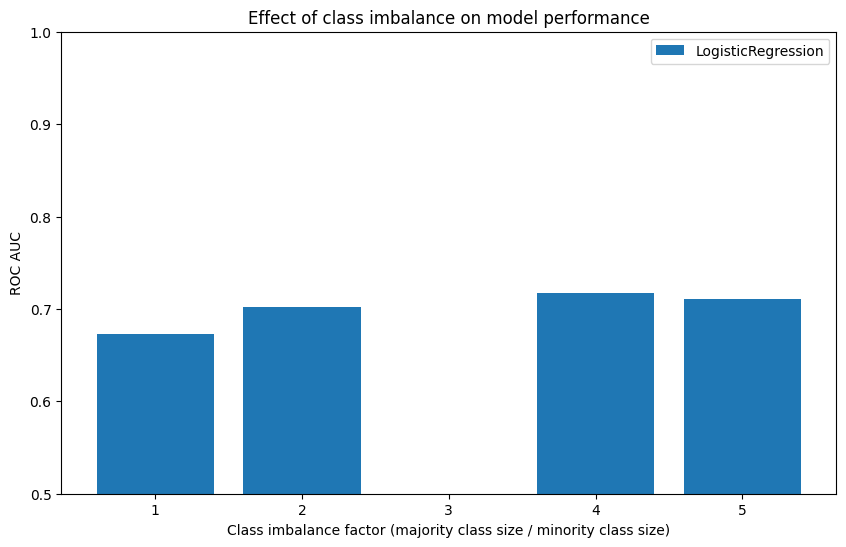

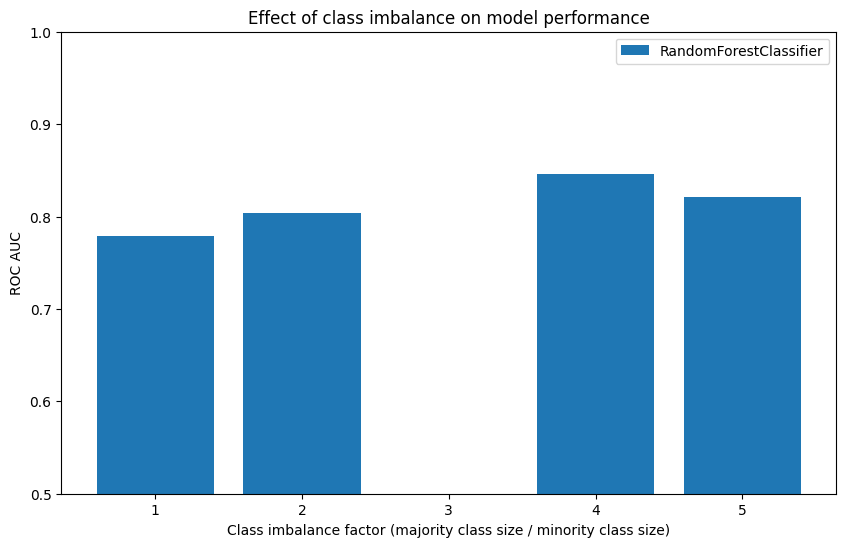

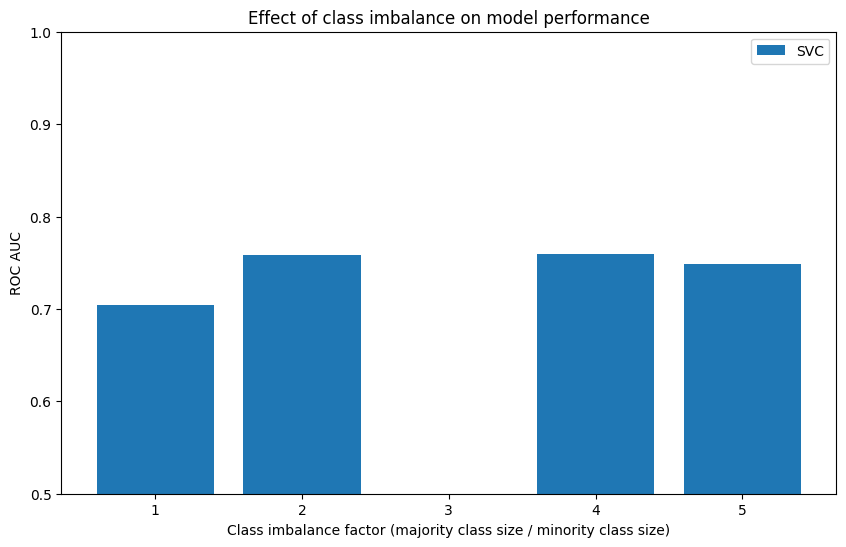

In [19]:
# plot the results
for model_name, roc_auc_list in model_roc_auc.items():
    plt.figure(figsize=(10,6))
    plt.bar(factors[:4], roc_auc_list[:4], label=model_name)
    plt.xlabel('Class imbalance factor (majority class size / minority class size)')
    plt.ylabel('ROC AUC')
    plt.ylim(0.5, 1)
    plt.title('Effect of class imbalance on model performance')
    plt.legend()
    plt.show()